In [1]:
import numpy as np
import itertools
import sys
import pyemma
import msmtools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm import tqdm_notebook

In [2]:
sys.path.append('/home/mi/thempel/code/information/')
import informant as inf

### driven Ising model
One spin periodically changes sign and is not influenced by the rest. This example: Spin 10, stays 10 steps and subsequently changes sign.

In [3]:
nspins = 10
nsteps = 100000
tau = 1. # for generation of the data; validated to be as large as possible to still reproduce eigenvalue spectrum
alpha_driver = .05
ntrials = 3

### generate dynamics
Use `ntrails = 3` realizations of the Markov chain.

In [4]:
states = np.zeros((ntrials, nspins, nsteps), dtype=np.int8)
for t in range(ntrials):
    states[t] = inf.generators.gen_ising_traj(nspins, 
                                              nsteps, 
                                              driven=True, 
                                              alpha_driver=None, # falls back to alpha of "normal" spins
                                              tau=tau)

### compute TE from driver to neighbor and between 2 random spins

In [5]:
msmlags = np.arange(1, 51)
te_driver2neighbor = np.zeros((ntrials, msmlags.shape[0], 2))
te_randomneighbors = np.zeros((ntrials, msmlags.shape[0], 2))

di_driver2neighbor = np.zeros((ntrials, msmlags.shape[0], 2))
di_randomneighbors = np.zeros((ntrials, msmlags.shape[0], 2))


for t in range(ntrials):
    for n, msmlag in enumerate(msmlags):
        # TE driver -> neighbor
        est_forw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_forw.estimate(states[t, 0], states[t, 1])
        
        # TE neighbor -> driver
        est_backw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_backw.estimate(states[t, 1], states[t, 0])
        
        te_driver2neighbor[t, n] = [est_forw.d, est_backw.d]
        
        # TE random spin -> neighbor of random spin
        est_forw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_forw.estimate(states[t, 5], states[t, 6])
        
        # TE neighbor of random spin -> random spin
        est_backw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_backw.estimate(states[t, 6], states[t, 5])

        te_randomneighbors[t, n] = [est_forw.d, est_backw.d]
        
        # DI driver -> neighbor
        est_forw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_forw.estimate(states[t, 0], states[t, 1])
        
        # DI neighbor -> driver
        est_backw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_backw.estimate(states[t, 1], states[t, 0])

        di_driver2neighbor[t, n] = [est_forw.d, est_backw.d]
        
        # DI random spin -> neighbor of random spin
        est_forw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_forw.estimate(states[t, 5], states[t, 6])
        
        # DI neighbor of random spin -> random spin
        est_backw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, reversible=False, tmat_ck_estimate=False))
        est_backw.estimate(states[t, 6], states[t, 5])
        
        di_randomneighbors[t, n] = [est_forw.d, est_backw.d]

### evaluate matrix of all spin-spin TE's at $\tau=10$

In [6]:
te_mat = np.zeros((states.shape[1], states.shape[1]))
di_mat = np.zeros((states.shape[1], states.shape[1]))

msmlag = 10
for i, j in itertools.combinations(range(states.shape[1]), 2):
    for t in range(ntrials):
        # TE forward
        est_forw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, 
                                   reversible=False, 
                                   tmat_ck_estimate=False))
        est_forw.estimate(states[t, i], states[t, j])
        
        # TE backward
        est_backw = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, 
                                   reversible=False, 
                                   tmat_ck_estimate=False))
        est_backw.estimate(states[t, j], states[t, i])

        te_mat[i, j] += est_forw.d
        te_mat[j, i] += est_backw.d        
        
        # DI forward
        est_forw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, 
                                   reversible=False, 
                                   tmat_ck_estimate=False))
        est_forw.estimate(states[t, i], states[t, j])
        
        # DI backward
        est_backw = inf.DirectedInformation(inf.MSMProbabilities(msmlag=msmlag, 
                                   reversible=False, 
                                   tmat_ck_estimate=False))
        est_backw.estimate(states[t, j], states[t, i])


        di_mat[i, j] += est_forw.d
        di_mat[j, i] += est_backw.d
                    
# compute mean
te_mat = te_mat / ntrials
di_mat = di_mat / ntrials

### plot into a combined figure

In [7]:
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['xtick.minor.pad'] = 2
mpl.rcParams['xtick.major.pad'] = 3
mpl.rcParams['ytick.minor.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 3
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['lines.markersize'] = 4

cmap = plt.cm.binary
backwcol, forwcol = plt.cm.seismic(0.2), plt.cm.seismic(.8)

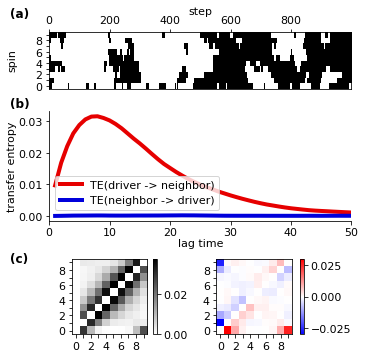

In [14]:
driver2neighbor = te_driver2neighbor
dmat = te_mat
dmat_forw_min_back = te_mat - te_mat.T

fig = plt.figure(figsize=(4.2, 4.2))
gw = 700
gh = 800
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(-0.13, 1.05, '(a)', size=12, fontweight='bold')
ax_box.text(-0.13, 0.75, '(b)', size=12, fontweight='bold')
ax_box.text(-0.13, 0.24, '(c)', size=12, fontweight='bold')


ax_ts = fig.add_subplot(gs[:150, :])
ax_ts.imshow(states[0, :,:1000], aspect='auto', cmap=cmap, interpolation='nearest')

ax_ts.set_ylim(-.5, nspins - .5) # turns y-axis bottom-up. is consistent. same above.

ax_ts.set_ylabel('spin')
ax_ts.set_xlabel('step')
ax_ts.set_yticks(range(nspins))
ax_ts.set_yticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                  np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins));
ax_ts.xaxis.tick_top()
ax_ts.xaxis.set_label_position('top')


ax_lag = fig.add_subplot(gs[210:500, :])

ax_lag.plot(msmlags, driver2neighbor[:, :, 0].mean(axis=0), lw=4, 
            label='TE(driver -> neighbor)', c=forwcol)
ax_lag.plot(msmlags, driver2neighbor[:, :, 1].mean(axis=0), lw=4, 
            label='TE(neighbor -> driver)', c=backwcol)
ax_lag.legend(loc=(.02, .1))
ax_lag.spines['top'].set_visible(False)
ax_lag.spines['right'].set_visible(False)
ax_lag.set_xlim(0, len(msmlags))

ax_lag.set_ylabel('transfer entropy')
ax_lag.set_xlabel('lag time')

ax_mat1 = fig.add_subplot(gs[600:, 50:230])
ax_colb1 = fig.add_subplot(gs[600:, 240:250])
img1 = ax_mat1.imshow(dmat, cmap=cmap)
fig.colorbar(img1, cax=ax_colb1)
ax_mat2 = fig.add_subplot(gs[600:, 380:570])
ax_colb2 = fig.add_subplot(gs[600:, 580:590])
img2 = ax_mat2.imshow(dmat_forw_min_back, cmap='bwr')
fig.colorbar(img2, cax=ax_colb2)

for ax_mat in [ax_mat1, ax_mat2]:
    ax_mat.set_xticks(range(nspins))
    ax_mat.set_yticks(range(nspins))
    ax_mat.set_yticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                      np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins))
    ax_mat.set_xticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                      np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins))
    ax_mat.set_ylim(-.5, nspins - .5)
    ax_mat.set_xlim(-.5, nspins - .5)


all_axs = [ax_ts, ax_mat, ax_lag]
for ax in all_axs:
    ax.set_facecolor((0, 0, 0, 0))
    
fig.align_labels(all_axs)
fig.savefig('/home/mi/thempel/Dokumente/Papers/paper_directed_networks/gfx/ising_simple.pdf', bbox_inches='tight')

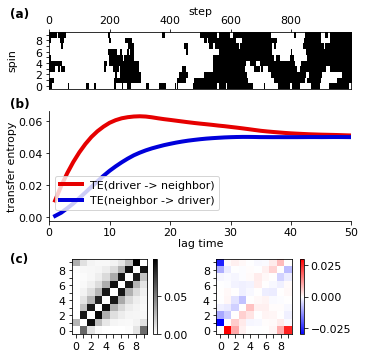

In [16]:
driver2neighbor = di_driver2neighbor
dmat = di_mat
dmat_forw_min_back = di_mat - di_mat.T

fig = plt.figure(figsize=(4.2, 4.2))
gw = 700
gh = 800
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(-0.13, 1.05, '(a)', size=12, fontweight='bold')
ax_box.text(-0.13, 0.75, '(b)', size=12, fontweight='bold')
ax_box.text(-0.13, 0.24, '(c)', size=12, fontweight='bold')


ax_ts = fig.add_subplot(gs[:150, :])
ax_ts.imshow(states[0, :,:1000], aspect='auto', cmap=cmap, interpolation='nearest')

ax_ts.set_ylim(-.5, nspins - .5) # turns y-axis bottom-up. is consistent. same above.

ax_ts.set_ylabel('spin')
ax_ts.set_xlabel('step')
ax_ts.set_yticks(range(nspins))
ax_ts.set_yticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                  np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins));
ax_ts.xaxis.tick_top()
ax_ts.xaxis.set_label_position('top')


ax_lag = fig.add_subplot(gs[210:500, :])

ax_lag.plot(msmlags, driver2neighbor[:, :, 0].mean(axis=0), lw=4, 
            label='TE(driver -> neighbor)', c=forwcol)
ax_lag.plot(msmlags, driver2neighbor[:, :, 1].mean(axis=0), lw=4, 
            label='TE(neighbor -> driver)', c=backwcol)
ax_lag.legend(loc=(.02, .1))
ax_lag.spines['top'].set_visible(False)
ax_lag.spines['right'].set_visible(False)
ax_lag.set_xlim(0, len(msmlags))

ax_lag.set_ylabel('transfer entropy')
ax_lag.set_xlabel('lag time')

ax_mat1 = fig.add_subplot(gs[600:, 50:230])
ax_colb1 = fig.add_subplot(gs[600:, 240:250])
img1 = ax_mat1.imshow(dmat, cmap=cmap)
fig.colorbar(img1, cax=ax_colb1)
ax_mat2 = fig.add_subplot(gs[600:, 380:570])
ax_colb2 = fig.add_subplot(gs[600:, 580:590])
img2 = ax_mat2.imshow(dmat_forw_min_back, cmap='bwr')
fig.colorbar(img2, cax=ax_colb2)

for ax_mat in [ax_mat1, ax_mat2]:
    ax_mat.set_xticks(range(nspins))
    ax_mat.set_yticks(range(nspins))
    ax_mat.set_yticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                      np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins))
    ax_mat.set_xticklabels(np.vstack([np.arange(0, nspins, 2).astype(str), 
                                      np.array(['' for _ in range(int(nspins/2))])]).T.reshape(nspins))
    ax_mat.set_ylim(-.5, nspins - .5)
    ax_mat.set_xlim(-.5, nspins - .5)


all_axs = [ax_ts, ax_mat, ax_lag]
for ax in all_axs:
    ax.set_facecolor((0, 0, 0, 0))
    
fig.align_labels(all_axs)
fig.savefig('/home/mi/thempel/Dokumente/Papers/paper_directed_networks/gfx/ising_simple_di.pdf', bbox_inches='tight')